# Time Series Forecasting

reference site : [Time Series Forecasting](https://h3imdallr.github.io/2017-08-19/arima/)

Analysis Gantry CPU using time Series with ARIMA

In [34]:
%matplotlib inline

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# EDA: 시계열 데이터 확인하기 
import datetime 
from dateutil.relativedelta import relativedelta

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
df = pd.read_csv('../csv_data/datasets_20066_26008_portland-oregon-average-monthly-.csv', index_col='Month')
#df = pd.read_csv('../../../csv_data/prophet_data.csv', index_col='date')
df.head()

,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
Month,
1960-01,648
1960-02,646
1960-03,639
1960-04,654
1960-05,630


In [38]:
df.dropna(axis=0, inplace=True)
df.columns = ['ridership']
print(df.head(), '\n...\n', df.tail())

        ridership
Month            
1960-01       648
1960-02       646
1960-03       639
1960-04       654
1960-05       630 
...
                                                    ridership
Month                                                       
1969-03                                                 1419
1969-04                                                 1432
1969-05                                                 1394
1969-06                                                 1327
Portland Oregon average monthly bus ridership (...     n=114


In [39]:
df = df.iloc[:-1]
print(df.tail())

        ridership
Month            
1969-02      1425
1969-03      1419
1969-04      1432
1969-05      1394
1969-06      1327


In [40]:
df.index = pd.to_datetime(df.index)
type(df.index); 
print(df.head(), '\n...\n', df.tail())

           ridership
Month               
1960-01-01       648
1960-02-01       646
1960-03-01       639
1960-04-01       654
1960-05-01       630 
...
            ridership
Month               
1969-02-01      1425
1969-03-01      1419
1969-04-01      1432
1969-05-01      1394
1969-06-01      1327


In [41]:
time_window_l = datetime.datetime(2020, 6, 29)
time_window_r = datetime.datetime(2020, 7, 10)
temp_df = df[
    (df.index >= time_window_l)
    & (df.index <= time_window_r)
]
print(temp_df)

Empty DataFrame
Columns: [ridership]
Index: []


In [42]:
temp_df = df[:time_window_l]
print(temp_df)

           ridership
Month               
1960-01-01       648
1960-02-01       646
1960-03-01       639
1960-04-01       654
1960-05-01       630
...              ...
1969-02-01      1425
1969-03-01      1419
1969-04-01      1432
1969-05-01      1394
1969-06-01      1327

[114 rows x 1 columns]


In [43]:
df['ridership'] = df['ridership'].astype(float)
print(df.dtypes)

ridership    float64
dtype: object


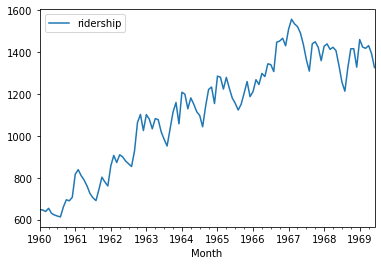

In [44]:
df.plot()

<Figure size 720x720 with 0 Axes>

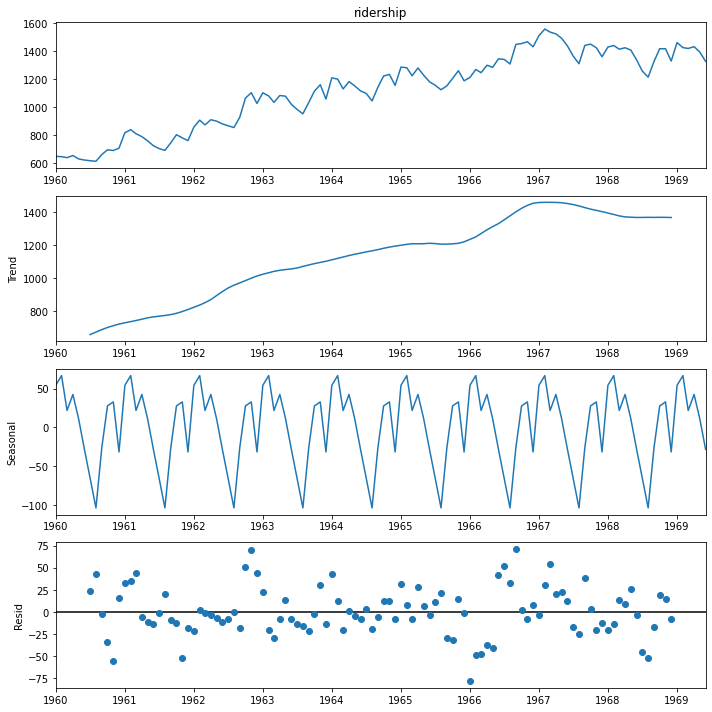

In [45]:
decomposition = seasonal_decompose(df['ridership'], period=12)
plt.rcParams['figure.figsize'] = [10,10]
fig = plt.figure()
fig = decomposition.plot()

In [46]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    fig = plt.figure(figsize=(10, 6 ))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    

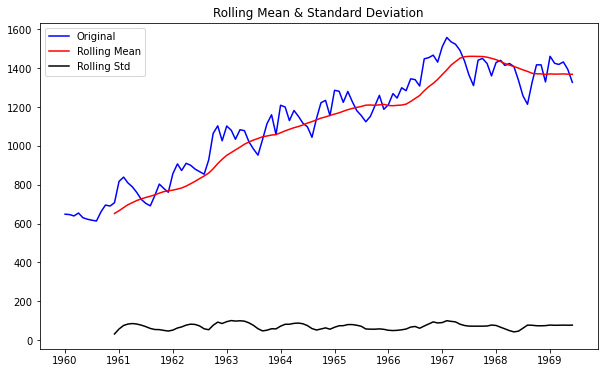

<Results of Dickey-Fuller Test>
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [47]:
test_stationarity(df['ridership'])

In [48]:
df['first_difference'] = df['ridership'] - df['ridership'].shift(1)

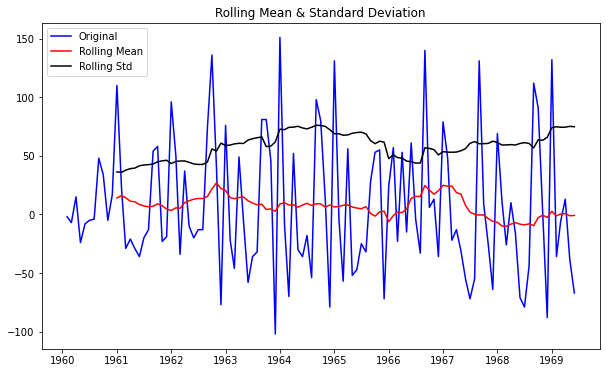

<Results of Dickey-Fuller Test>
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [49]:
test_stationarity(df.first_difference.dropna(inplace=False))

In [50]:
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(12)

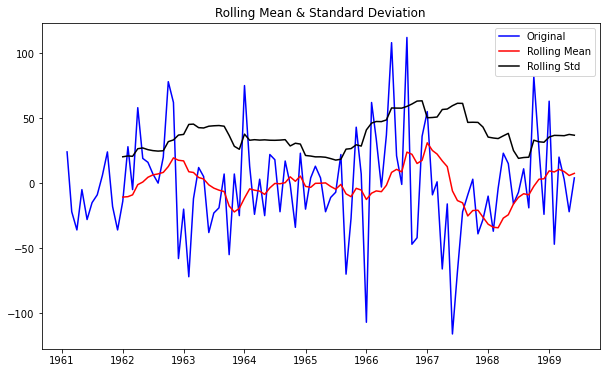

<Results of Dickey-Fuller Test>
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [51]:
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


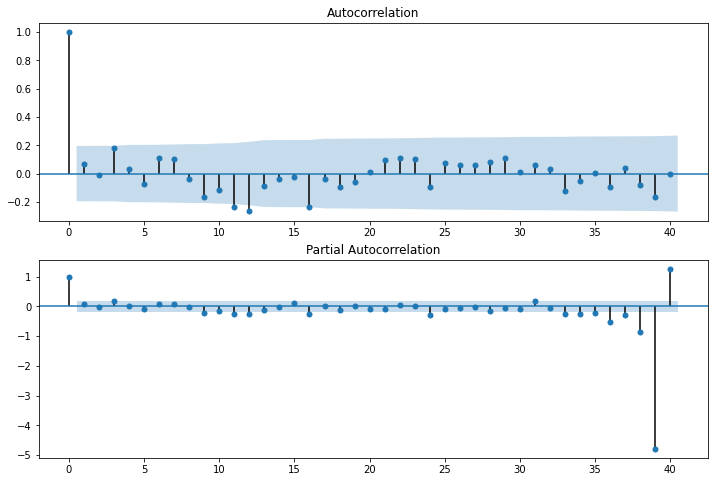

In [52]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:],lags=40,ax=ax2)

In [53]:
mod = sm.tsa.SARIMAX(df['ridership'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                            ridership   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -501.340
Date:                              Fri, 10 Jul 2020   AIC                           1008.680
Time:                                      05:39:00   BIC                           1016.526
Sample:                                  01-01-1960   HQIC                          1011.856
                                       - 06-01-1969                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3236      0.186      1.739      0.082      -0.041       0.688
ma.S.L12      -0.99

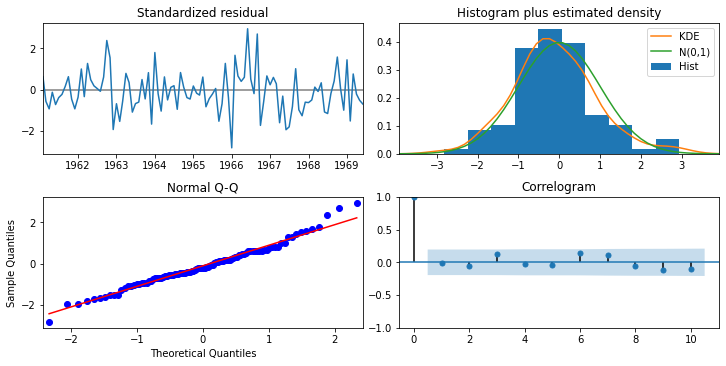

In [54]:
plt.rcParams['figure.figsize'] = [10,5]
results.plot_diagnostics();
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

,ridership,first_difference,seasonal_first_difference,forecast
Month,,,,
1967-07-01,1365.0,-72.0,-68.0,NaN
1967-08-01,1310.0,-55.0,-22.0,NaN
1967-09-01,1441.0,131.0,-9.0,NaN
1967-10-01,1450.0,9.0,3.0,NaN
1967-11-01,1424.0,-26.0,-39.0,NaN
1967-12-01,1360.0,-64.0,-28.0,NaN
1968-01-01,1429.0,69.0,-10.0,NaN
1968-02-01,1440.0,11.0,-37.0,NaN
1968-03-01,1414.0,-26.0,-4.0,NaN


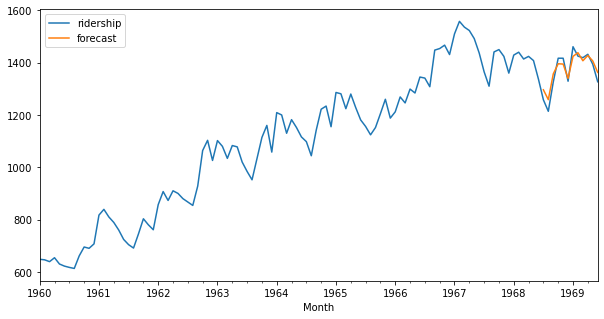

In [55]:
# 시계열 예측
df['forecast'] = results.predict(start = len(df)-12, end= len(df), dynamic= True)  
df[['ridership', 'forecast']].plot()
df[-24:]

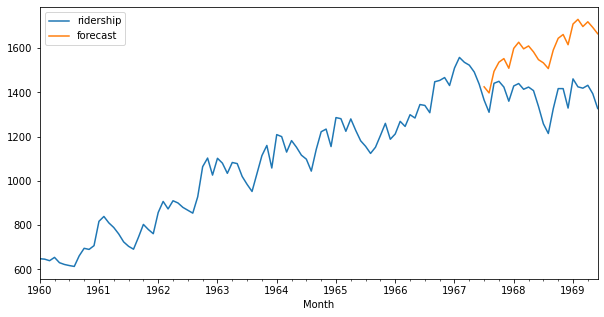

In [56]:
# 24개월 예측
df['forecast'] = results.predict(start = len(df)-24, end= len(df), dynamic= True)  
df[['ridership', 'forecast']].plot()

In [57]:
#start = datetime.datetime.strptime("2020-07-01", "%Y-%m-%d")
## >2020-07-01 00:00:00
#date_list = [start + relativedelta(months=x) for x in range(0,12)]
##> 1982/7/1,8/1, ... 1983/6/1

#future_df = pd.DataFrame(index=date_list, columns= df.columns)
#new_df = pd.concat([df, future_df]) #concatenated  dataframe
## print(new_df.head(),'\n...\n',new_df.tail())

In [58]:
#new_df['forecast'] = results.predict(start = len(df), end = len(df)+11, dynamic= True)  
#new_df[['ridership', 'forecast']].ix[-48:].plot()

In [59]:
#print(df.forecast[-12:])